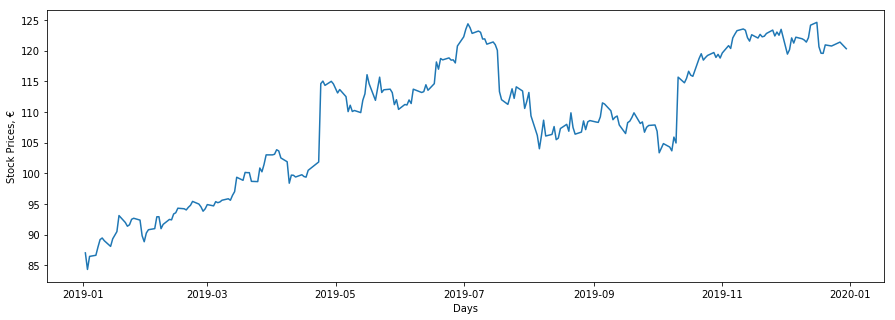

,Date,Close
245,2019-12-19,119.56
246,2019-12-20,120.94
247,2019-12-23,120.76
248,2019-12-27,121.40
249,2019-12-30,120.32


In [55]:
#importing SAP data from FSE
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot of SAP
# stock prices since beginning of 2019 (up to July)

#Change here the code for a different stock ("FSE/SAP_X")
prices = quandl.get("FSE/SAP_X", 
                authtoken="bxu7nmGXAGZH4AWi1kW7", 
                start_date = '2019-01-01', end_date = '2019-12-31'
                ).reset_index(drop = False)[['Date', 'Close']]
                
plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()
prices.tail()


0.0014298989957165376 0.01618979778772199


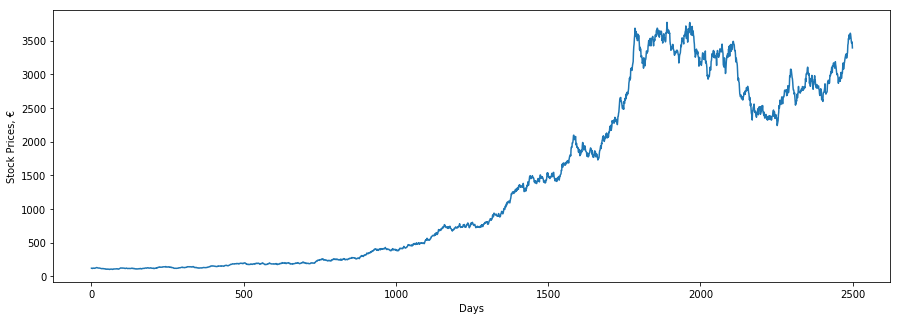

In [233]:
##Simulating the stock prices using GBM

#Set the simulation size here
sim_size = 2500

#Simulation Procedure
#Assuming that Stock price to be the last price of the given data (i.e. on 2019-12-30)
close = prices['Close']
mu = close.pct_change().iloc[0:250].mean()
sigma = close.pct_change().iloc[0:250].std()
print(mu,sigma)
simulation = np.zeros((sim_size,1))
time=np.zeros((sim_size,1))
time[0] = 0
simulation[0] = close[249]

for day in range(1,sim_size):
    time[day]=day
    ins = mu - ((sigma**2)/2) + sigma*np.random.normal()
    term = np.exp(ins)
    simulation[day] = simulation[day-1]*term

#Simulated Data Plot
plt.figure(figsize = (15, 5))
plt.plot(time,simulation)
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()

In [232]:
#creating dataset for ML modelling
df = pd.DataFrame(time)
df['close'] = simulation
df.columns = ['t','close']
new_col = np.where(df.close >= df.close.shift(1), 1, 0)  
new_col = new_col[1:]
new_df = df.iloc[:sim_size-1]
new_df['target'] = new_col

#normalising dataset
training_set = new_df.iloc[:, 1:2].values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

2499 2499
           t        close  target
0        0.0   120.320000       1
1        1.0   121.638017       1
2        2.0   123.202276       1
3        3.0   126.570811       1
4        4.0   128.983385       1
5        5.0   132.543485       1
6        6.0   133.696348       0
7        7.0   132.820616       1
8        8.0   135.844145       1
9        9.0   137.946123       1
10      10.0   140.947581       1
11      11.0   143.212329       1
12      12.0   143.765969       0
13      13.0   143.201917       0
14      14.0   140.962160       0
15      15.0   140.584743       1
16      16.0   143.025028       1
17      17.0   145.351197       0
18      18.0   144.480766       0
19      19.0   144.358903       0
20      20.0   142.601194       0
21      21.0   141.290910       0
22      22.0   141.035557       1
23      23.0   143.738234       1
24      24.0   145.519717       1
25      25.0   149.193294       0
26      26.0   149.064658       0
27      27.0   147.838146       1
28  

/home/anshul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


array([[0.00000000e+00],
       [2.90106293e-04],
       [6.34412244e-04],
       ...,
       [9.37413551e-01],
       [9.22266921e-01],
       [9.21792250e-01]])

In [219]:
#creating training dataset and split training-testing
x_train = []
y_train = []
timestamp = 60
length = len(training_set)
for i in range(timestamp, length):
    x_train.append(training_set_scaled[i-timestamp:i, 0])
    y_train.append(np.where(training_set_scaled[i, 0]>=training_set_scaled[i-1, 0],1,0))
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

df_x = x_train
df_y = y_train

train_size = int(len(df_x) * 0.70)
x_train, x_test = df_x[0:train_size], df_x[train_size:len(df_x)]
y_train, y_test = df_y[0:train_size], df_y[train_size:len(df_y)]

print('Observations: %d' % (len(df_x)))
print('Training Observations of X: %d' % (len(x_train)))
print('Testing Observations of X: %d' % (len(x_test)))
print('Training Observations of y: %d' % (len(y_train)))
print('Testing Observations of y: %d' % (len(y_test)))

Observations: 189
Training Observations: 132
Testing Observations: 57
Training Observations: 132
Testing Observations: 57


In [220]:
#Model Setup
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()

model.add(LSTM(units = 10, return_sequences = False, input_shape = (x_train.shape[1], 1)))
#model.add(LSTM(units = 10,return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [223]:
#Training and Evaluation
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=10)
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Train on 132 samples, validate on 57 samples
Epoch 1/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4924 - val_loss: 0.6933 - val_accuracy: 0.4561
Epoch 2/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5379 - val_loss: 0.6950 - val_accuracy: 0.4211
Epoch 3/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5076 - val_loss: 0.6971 - val_accuracy: 0.4211
Epoch 4/100
132/132 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5076 - val_loss: 0.6952 - val_accuracy: 0.4211
Epoch 5/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.5076 - val_loss: 0.6966 - val_accuracy: 0.4211
Epoch 6/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.5076 - val_loss: 0.6963 - val_accuracy: 0.4211
Epoch 7/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5

132/132 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6136 - val_loss: 0.7503 - val_accuracy: 0.5088
Epoch 58/100
132/132 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6061 - val_loss: 0.7670 - val_accuracy: 0.5263
Epoch 59/100
132/132 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6288 - val_loss: 0.7640 - val_accuracy: 0.5088
Epoch 60/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6566 - accuracy: 0.6212 - val_loss: 0.7744 - val_accuracy: 0.5263
Epoch 61/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6649 - accuracy: 0.6212 - val_loss: 0.7564 - val_accuracy: 0.5263
Epoch 62/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6627 - accuracy: 0.5833 - val_loss: 0.7597 - val_accuracy: 0.5263
Epoch 63/100
132/132 [==============================] - 0s 2ms/step - loss: 0.6588 - accuracy: 0.6288 - val_loss: 0.7647 - val_accuracy: 0.5088
Epoch

In [ ]:
#Reference

# 'https://towardsdatascience.com/simulating-stock-prices-in-python-using-geometric-brownian-motion-8dfd6e8c6b18'
# 'https://blog.quantinsti.com/random-walk-geometric-brownian-motion/#'
# 'https://www.kaggle.com/pankul/lstm-stock-price-movement-prediction'
# 'https://machinelearningmastery.com/keras-functional-api-deep-learning/'